# Heating-induced contraction
- Gough-Joule-effect: Contraction of a stretched rubber cylinder upon heating
- This  is an axi-symmetric simulation is performed  in two steps:
- Step 1: Subject the cylinder to  an axial traction ramped from 0 to 2MPa, while maintianing the
        temperature constant at 298K on its exterior faces   
- Step 2: While keeping the end traction constant, ramp
        up the boundary temperature from 298 to 348K and then hold  it constant for a while

Accompanies the book, 
- L. Anand, E.M. Stewart, S.A. Chester. _Introduction to coupled theories in solid mechanics_. 2025, in preparation.


# Units
- Length: mm
- Mass: kg
- Time: s
- Mass density: kg/mm^3
- Force: milliN
- Stress: kPa 
- Energy: microJ
- Temperature: K
- Boltzmann Constant: 1.38E-17 microJ/K
- Number of polymer chains per unit vol: #/mm^3
- Thermal expansion coefficient: #/K
- Specific heat: microJ/(mm^3 K)
- Thermal conductivity: microW/(mm K)

### Software:
- Dolfinx v0.8.0

Eric Stewart and Lallit Anand  

ericstew@mit.edu and anand@mit.edu   

June 2024

# Import modules

In [1]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# Specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile

# Specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, inner, derivative, dot, ln, split, exp, eq, cos, sin, acos, ge, le, outer, tanh,\
                 cosh, atan, atan2)

# basix finite elements (necessary for dolfinx v0.8.0)
import basix
from basix.ufl import element, mixed_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime

# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [2]:
# Create mesh 
R0 = 10.0  # radius of bar
H0 = 10.0  # height of bar
domain = mesh.create_rectangle(MPI.COMM_WORLD, [[0.0,0.0], [R0,H0]],\
                         [20,20], mesh.CellType.triangle, diagonal=mesh.DiagonalType.crossed)

x = ufl.SpatialCoordinate(domain)

**Identify the boundaries of the domain**

In [3]:
# Identify the boundaries of the  rectangle mesh
#
def xBot(x):
    return np.isclose(x[0], 0)
def xTop(x):
    return np.isclose(x[0], R0)
def yBot(x):
    return np.isclose(x[1], 0)
def yTop(x):
    return np.isclose(x[1], H0)
    
# Mark the sub-domains
boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop)]

# Identify the bottom left corner       
def Ground(x):
        return np.isclose(x[0], 0) and np.isclose(x[1], 0)


# Build collections of facets on each subdomain and mark them appropriately.
facet_indices, facet_markers = [], [] # initalize empty collections of indices and markers.
fdim = domain.topology.dim - 1        # geometric dimension of the facet (mesh dimension - 1)
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator) # an array of all the facets in a 
                                                         # given subdomain ("locator")
    facet_indices.append(facets)                         # add these facets to the collection.
    facet_markers.append(np.full_like(facets, marker))   # mark them with the appropriate index.

# Format the facet indices and markers as required for use in dolfinx.
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
# 
# Add these marked facets as "mesh tags" for later use in BCs.
facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

**Visualize reference configuration and boundary facets**

In [4]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid, show_edges=True) 

plotter.view_xy()

#labels = dict(zlabel='Z', xlabel='X', ylabel='Y')
labels = dict(xlabel='X', ylabel='Y')
plotter.add_axes(**labels)

    
plotter.screenshot("results/bar_mesh.png")

from IPython.display import Image
Image(filename='results/bar_mesh.png') 

# Use the following  commands for a  zoom-able  view
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot("mesh.png")

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

## Define boundary and volume integration measure

In [5]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':4})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, metadata={'quadrature_degree': 4})

# Create facet to cell connectivity required to determine boundary facets.
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim)
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)
domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

# #  Define facet normal
n2D = ufl.FacetNormal(domain)
n = ufl.as_vector([n2D[0], n2D[1], 0.0]) # define n as a 3D vector for later use

# Material parameters

In [6]:
k_B      = Constant(domain,PETSc.ScalarType(1.38E-17))             # Boltzmann's constant
theta0   = Constant(domain,PETSc.ScalarType(298))                  # Initial temperature
Gshear_0 = Constant(domain,PETSc.ScalarType(280))                  # Ground sate shear modulus
N_R      = Constant(domain,PETSc.ScalarType(Gshear_0/(k_B*theta0)))# Number polymer chains per unit ref. volume
lambdaL  = Constant(domain,PETSc.ScalarType(5.12))                 # Locking stretch
Kbulk    = Constant(domain,PETSc.ScalarType(1000*Gshear_0))        # Bulk modulus
alpha    = Constant(domain,PETSc.ScalarType(180.0E-6))             # Coefficient of thermal expansion
c_v      = Constant(domain,PETSc.ScalarType(1839))                 # Specific heat
k_therm  = Constant(domain,PETSc.ScalarType(0.16E3))               # Thermal conductivity

# Simulation time-control related parameters

In [7]:
t          = 0.0       
step1_time = 50   
# 
step2_ramp = 50  # In Step 2 the  temperature is ramped up by 50K over 50 seconds             
step2_time = 250 # and then held constant for 200 seconds               
#
Ttot = step1_time + step2_time  
#
dt   = 2           # Fixed  time step size

# Function spaces

In [8]:
# Define function space, both vectorial and scalar
#  
U2 = element("Lagrange", domain.basix_cell(), 2, shape=(2,)) # For displacement
P1 = element("Lagrange", domain.basix_cell(), 1)             # For  pressure and temperature                                        
#
TH = mixed_element([U2, P1, P1])  # Taylor-Hood style mixed element
ME = functionspace(domain, TH)    # Total space for all DOFs

# Define actual functions with the required DOFs
w = Function(ME)
u, p, theta = split(w)  # displacement u, pressure p, temperature theta

# A copy of functions to store values in the previous step for time-stepping
w_old = Function(ME)
u_old,  p_old, theta_old = split(w_old)   

# Define test functions    
u_test, p_test,  theta_test = TestFunctions(ME)  

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)                  

# Assign initial  temperature  theta0 to the whole domain 
w.sub(2).interpolate(lambda x: np.full((x.shape[1],),  theta0))
w_old.sub(2).interpolate(lambda x: np.full((x.shape[1],),  theta0))    

# Subroutines for kinematics and constitutive equations

In [9]:
# Special gradient operators for axisymmetric functions 
#
# Gradient of vector field u   
def axi_grad_vector(u):
    
    grad_u = grad(u)
    
    axi_grad_33_exp = conditional(eq(x[0], 0), 0.0, u[0]/x[0])
    
    axi_grad_u = ufl.as_tensor([[grad_u[0,0], grad_u[0,1], 0],
                  [grad_u[1,0], grad_u[1,1], 0],
                  [0, 0, axi_grad_33_exp]]) 
    
    return axi_grad_u

# Gradient of scalar field y
# (just need an extra zero for dimensions to work out)
def axi_grad_scalar(y):
    
    grad_y = grad(y)
    
    axi_grad_y = ufl.as_vector([grad_y[0], grad_y[1], 0.])
    
    return axi_grad_y

# Axisymmetric deformation gradient 
def F_axi_calc(u):
    
    dim = len(u)                # dimension of problem (2)
    
    Id = Identity(dim)          # 2D Identity tensor
    
    F = Id + grad(u)            # 2D Deformation gradient
    
    F33_exp =  1.0 + u[0]/x[0]  # axisymmetric F33, R/R0 
    
    F33 = conditional(eq(x[0], 0.0), 1.0, F33_exp) # avoid divide by zero at r=0
      
    F_axi =  ufl.as_tensor([[F[0,0], F[0,1], 0],
                  [F[1,0], F[1,1], 0],
                  [0, 0, F33]]) # Full axisymmetric F
    
    return F_axi

def lambdaBar_calc(u):
    F = F_axi_calc(u)
    C = F.T*F
    Cdis = J**(-2/3)*C
    I1 = tr(Cdis)
    lambdaBar = sqrt(I1/3.0)
    return lambdaBar

def zeta_calc(u):
    lambdaBar = lambdaBar_calc(u)
    # Use Pade approximation of Langevin inverse
    z    = lambdaBar/lambdaL
    z    = conditional(gt(z,0.95), 0.95, z) # Keep simulation from blowing up
    beta = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta = (lambdaL/(3*lambdaBar))*beta
    return zeta

#----------------------------------------------
# Subroutine for calculating the Piola  stress
#----------------------------------------------
def Piola_calc(u, p, theta):
    F = F_axi_calc(u)
    J = det(F)
    C = F.T*F
    #
    zeta = zeta_calc(u)
    Gshear  = N_R * k_B * theta * zeta
    #
    Piola = J**(-2/3) * Gshear * (F - (1/3)*tr(C)*inv(F.T) ) - J * p * inv(F.T)
    return Piola

#--------------------------------------------------------------
# Subroutine for calculating the stress temperature tensor
#--------------------------------------------------------------
def M_calc(u):
    Id  = Identity(3)         
    F   = F_axi_calc(u) 
    #
    C  = F.T*F
    Cinv = inv(C) 
    J = det(F)
    zeta = zeta_calc(u)
    #
    fac1 = N_R * k_B * zeta
    fac2 = (3*Kbulk*alpha)/J
    #
    M =  J**(-2/3) * fac1 * (Id - (1/3)*tr(C)*Cinv)  - J * fac2 * Cinv
    return M

#--------------------------------------------------------------
# Subroutine for calculating the heat flux
#--------------------------------------------------------------
def Heat_flux_calc(u, theta):
    F = F_axi_calc(u) 
    J = det(F)         
    #
    Cinv = inv(F.T*F) 
    #
    Tcond = J * k_therm * Cinv # Thermal conductivity tensor
    #
    Qmat = - Tcond * axi_grad_scalar(theta)
    return Qmat

#--------------------------------------------------------------------------------
# Subroutine for calculating the principal Cauchy stress  for visualization if needed
#--------------------------------------------------------------------------------
def tensor_eigs(T):
    # invariants of T
    I1 = tr(T) 
    I2 = (1/2)*(tr(T)**2 - tr(T*T))
    I3 = det(T)
    
    # Intermediate quantities b, c, d
    b = -I1
    c = I2
    d = -I3
    
    # intermediate quantities E, F, G
    E = (3*c - b*b)/3
    F = (2*(b**3) - 9*b*c + 27*d)/27
    G = (F**2)/4 + (E**3)/27
    
    # Intermediate quantities H, I, J, K, L
    H = sqrt(-(E**3)/27)
    I = H**(1/3)
    J = acos(-F/(2*H))
    K = cos(J/3)
    L = sqrt(3)*sin(J/3)
    
    # Finally, the (not necessarily ordered) eigenvalues
    t1 = 2*I*K - b/3
    t2 = -I*(K+L) - b/3
    t3 = -I*(K-L) - b/3
    
    # Order the eigenvalues using conditionals
    #
    T1_temp = conditional(lt(t1, t3), t3, t1 ) # returns the larger of t1 and t3.
    T1 = conditional(lt(T1_temp, t2), t2, T1_temp ) # returns the larger of T1_temp and t2.
    #
    T3_temp = conditional(gt(t3, t1), t1, t3 ) # returns the smaller of t1 and t3.
    T3 = conditional(gt(T3_temp, t2), t2, T1_temp ) # returns the smaller of T3_temp and t2.
    #
    # use the trace to report the middle eigenvalue.
    T2 = I1 - T1 - T3
    
    return T1, T2, T3

# Evaluate kinematics and constitutive relations

In [10]:
# Kinematics
F = F_axi_calc(u)
J = det(F)   
#
lambdaBar = lambdaBar_calc(u)
#
F_old = F_axi_calc(u_old)
J_old = det(F_old)   
#
C     = F.T*F
C_old = F_old.T*F_old

#  Piola stress
Piola = Piola_calc(u, p, theta)

# Calculate the stress-temperature tensor
M = M_calc(u)

# Calculate the heat flux
Qmat = Heat_flux_calc(u,theta)

# Weak forms

In [11]:
# Residuals:
# Res_0: Balance of forces (test fxn: u)
# Res_1: Coupling pressure (test fxn: p)
# Res_2: Balance of energy  (test fxn: theta)

# Expression for traction bc
trac_max = Constant(domain,PETSc.ScalarType(2000)) # 2000 kPa = 2MPa
#
def tracRamp(t):
    if t <= step1_time:
        traction_temp = trac_max*t/step1_time
    else: 
        traction_temp = trac_max
    return traction_temp

trac_cons = Constant(domain,PETSc.ScalarType(tracRamp(0)))

# Define 3D traction vector
traction = ufl.as_vector([0.0, trac_cons, 0.0])  
                                           
# Time step constant within domain
dk = Constant(domain, PETSc.ScalarType(dt))

# The weak form for the equilibrium equation
Res_0 = inner(Piola, axi_grad_vector(u_test))*x[0]*dx\
        - dot(traction, ufl.as_vector([u_test[0], u_test[1], 0.0]))*x[0]*ds(4)

# The weak form for the pressure
fac_p =  ( ln(J) - 3*alpha*(theta-theta0) )/J
#
Res_1 = dot( (p/Kbulk + fac_p), p_test)*x[0]*dx
      

# The weak form for heat equation
Res_2 = dot( c_v*(theta - theta_old), theta_test)*x[0]*dx \
        -  (1/2)*theta * inner(M, (C - C_old)) * theta_test*x[0]*dx \
        -  dk*dot(Qmat , axi_grad_scalar(theta_test) )*x[0]*dx   
        
# Total weak form
Res = Res_0 +  Res_1 + Res_2 

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

# Set-up output files

In [12]:
# Set up projection problem for fixing visualization of fields in axisymmetric simulations
#
def setup_projection(u, V):

    trial = ufl.TrialFunction(V)
    test  = ufl.TestFunction(V)   

    a = ufl.inner(trial, test)*x[0]*dx
    L = ufl.inner(u, test)*x[0]*dx

    projection_problem = dolfinx.fem.petsc.LinearProblem(a, L, [], \
        petsc_options={"ksp_type": "cg", "ksp_rtol": 1e-16, "ksp_atol": 1e-16, "ksp_max_it": 1000})
    
    return projection_problem

In [13]:
# results file name
results_name = "Axi_thermoelas_steps"

# Function space for projection of results
U1 = element("DG", domain.basix_cell(), 1, shape=(2,)) # For displacement
P0 = element("DG", domain.basix_cell(), 1)             # For  pressure and temperature  
T1 = element("DG", domain.basix_cell(), 1, shape=(3,3))# For stress tensor

V1 = fem.functionspace(domain, P0) # Scalar function space
V2 = fem.functionspace(domain, U1) # Vector function space
V3 = fem.functionspace(domain, T1) # linear tensor function space

# fields to write to output file
u_vis = Function(V2)
u_vis.name = "disp"

p_vis = Function(V1)
p_vis.name = "p"

theta_vis = Function(V1)
theta_vis.name = "theta"

J_vis = Function(V1)
J_vis.name = "J"
J_expr = Expression(J,V1.element.interpolation_points())

lambdaBar_vis = Function(V1)
lambdaBar_vis.name = "lambdaBar"
lambdaBar_expr = Expression(lambdaBar,V1.element.interpolation_points())

# Project the Piola stress tensor for visualization.
Piola_projection = setup_projection(Piola, V3)
Piola_temp = Piola_projection.solve()

T   = Piola_temp*F.T/J
T0   = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_projection = setup_projection(Mises, V1)
Mises_vis = Mises_projection.solve()
Mises_vis.name = "Mises"

P11 = Function(V1)
P11.name = "P11"
P11_expr = Expression(Piola_temp[0,0],V1.element.interpolation_points())
P22 = Function(V1)
P22.name = "P22"
P22_expr = Expression(Piola_temp[1,1],V1.element.interpolation_points())
P33 = Function(V1)
P33.name = "P33"
P33_expr = Expression(Piola_temp[2,2],V1.element.interpolation_points())

# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, p_vis, theta_vis, J_vis, P11, P22, P33, 
        lambdaBar_vis,Mises_vis,
    ],
    engine="BP4",
)

def writeResults(t):
       
       # re-project stress-related quantities for visualization
       # This is necessary here to remove visual artifacts which arise due to the axisymmetric formulation as r -> 0.
       Piola_temp = Piola_projection.solve()
       Mises_vis  = Mises_projection.solve()

       # Output field interpolation 
       u_vis.interpolate(w.sub(0))
       p_vis.interpolate(w.sub(1))
       theta_vis.interpolate(w.sub(2))
       J_vis.interpolate(J_expr)
       P11.interpolate(P11_expr)
       P22.interpolate(P22_expr)
       P33.interpolate(P33_expr)
       lambdaBar_vis.interpolate(lambdaBar_expr)
       # (Piola stress and Mises stress do not need to be re-interpolated after projection)

       # Write output fields
       file_results.write(t) 
        

# Infrastructure for pulling out time history data (force, displacement, etc.)

In [14]:
# Identify point for storing dispalcement and temperature history data
pointForDisp = np.array([0.0,H0,0.0])

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForDisp)
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForDisp).array
 

# boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop)]
# Compute the reaction force using the Piola stress field
RxnForce = fem.form(2*np.pi*P22*x[0]*ds(4))  

# Analysis Step 1

In [15]:
# Give the step a descriptive name
step = "Step 1"

## Boundary conditions

In [16]:
# Recall the sub-domains names and numbers
# boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop)]

# Find the specific DOFs which will be constrained.
xBot_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(1))
xTop_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(2))
yBot_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(3))
yTop_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(4))

xBot_theta_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(1))
xTop_theta_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(2))
yBot_theta_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(3))
yTop_theta_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(4))

# Dirichlet BCs for dispalcement and temperature
bcs_1 = dirichletbc(0.0, xBot_u1_dofs, ME.sub(0).sub(0))  # u1 fix - xBot
bcs_2 = dirichletbc(0.0, yBot_u2_dofs, ME.sub(0).sub(1))  # u2 fix - yBot
#
bcs_3 = dirichletbc(theta0, xTop_theta_dofs, ME.sub(2))   # Temperature fix - xTop
bcs_4 = dirichletbc(theta0, yBot_theta_dofs, ME.sub(2))   # Temperature fix - yBot
bcs_5 = dirichletbc(theta0, yTop_theta_dofs, ME.sub(2))   # Temperature fix - yTop

bcs = [bcs_1, bcs_2, bcs_3, bcs_4, bcs_5]

## Define the nonlinear variational problem

In [17]:
# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# The global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly" # "preonly" works equally well
opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()

# Initialize arrays for storing output history

In [18]:
# Arrays for storing output history
totSteps = 100000
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps]) 
timeHist2 = np.zeros(shape=[totSteps]) 
timeHist3 = np.zeros(shape=[totSteps])
#
timeHist3[0] = theta0 # Initialize the temperature

# Initialize a counter for reporting data
ii=0

# Write initial state to file
writeResults(t=0.0) 

##  Start calculation loop

In [19]:
# Print message for simulation start
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()

# Time-stepping solution procedure loop
while (round(t + dt, 9) <= step1_time):
     
    # increment time
    t += dt 
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    trac_cons.value = float(tracRamp(t))
    
    # Solve the problem
    try:
        (iter, converged) = solver.solve(w)
    except: # Break the loop if solver fails
        print("Ended Early")
        break
    
    # Collect results from MPI ghost processes
    w.x.scatter_forward()
    
    # Write output to file
    writeResults(t)
    
    # Update DOFs for next step
    w_old.x.array[:] = w.x.array
   
    # Store  output history at a particular point  at current time
    #
    timeHist0[ii] = t                                                        # time
    #
    timeHist1[ii] = w.sub(0).sub(1).eval([0.0,H0,0.0],colliding_cells[0])[0] # displacement
    #
    timeHist2[ii] = domain.comm.gather(fem.assemble_scalar(RxnForce))[0]     # reaction force
    #
    timeHist3[ii] = w.sub(2).eval([0.0,H0,0.0],colliding_cells[0])[0]        #  temperature

    # Print progress of calculation
    if ii%1 == 0:      
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: {} | Increment: {}, Iterations: {}".\
              format(step, ii, iter))
        print("      Simulation Time: {} s  of  {} s".\
              format(round(t,4), step1_time))
        print()  
    

------------------------------------
Simulation Start
------------------------------------
Step: Step 1 | Increment: 1, Iterations: 5
      Simulation Time: 2.0 s  of  50 s

Step: Step 1 | Increment: 2, Iterations: 5
      Simulation Time: 4.0 s  of  50 s

Step: Step 1 | Increment: 3, Iterations: 5
      Simulation Time: 6.0 s  of  50 s

Step: Step 1 | Increment: 4, Iterations: 5
      Simulation Time: 8.0 s  of  50 s

Step: Step 1 | Increment: 5, Iterations: 5
      Simulation Time: 10.0 s  of  50 s

Step: Step 1 | Increment: 6, Iterations: 5
      Simulation Time: 12.0 s  of  50 s

Step: Step 1 | Increment: 7, Iterations: 5
      Simulation Time: 14.0 s  of  50 s

Step: Step 1 | Increment: 8, Iterations: 4
      Simulation Time: 16.0 s  of  50 s

Step: Step 1 | Increment: 9, Iterations: 4
      Simulation Time: 18.0 s  of  50 s

Step: Step 1 | Increment: 10, Iterations: 4
      Simulation Time: 20.0 s  of  50 s

Step: Step 1 | Increment: 11, Iterations: 4
      Simulation Time: 22.0 

# Analysis Step 2

In [20]:
# Give the step a descriptive name
step = "Step 2"

# Boundary conditions

In [21]:
# thetaRamp = Expression("t >= step1_time ? \
#                        min(theta0 + deltaTheta*(t-step1_time)/tRamp, theta0 + deltaTheta):theta0", \
#             theta0 = 298, deltaTheta = 50, t= 0.0, step1_time=step1_time, tRamp = step2_ramp, degree=1)


# Temperature increase deltaTheta =50K
deltaTheta = Constant(domain,PETSc.ScalarType(50))

# Temperature bc history
def thetaRamp(t):
    if t<= step1_time:
       temperature = theta0
    elif step1_time < t <= (step1_time + step2_ramp):
       temperature = theta0 + deltaTheta*(t-step1_time)/step2_ramp
    elif t >= (step1_time + step2_ramp):
       temperature = theta0 + deltaTheta
    return temperature

# Constant for applied temperature
theta_cons = Constant(domain,PETSc.ScalarType(thetaRamp(0)))


# Mark the sub-domains
# boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop)]

# Find the specific DOFs which will be constrained.
xBot_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(1))
xTop_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(2))
yBot_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(3))
yTop_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(4))

xBot_theta_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(1))
xTop_theta_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(2))
yBot_theta_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(3))
yTop_theta_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(4))

# building Dirichlet BCs
bcs_1 = dirichletbc(0.0, xBot_u1_dofs, ME.sub(0).sub(0))  # u1 fix - xBot
bcs_2 = dirichletbc(0.0, yBot_u2_dofs, ME.sub(0).sub(1))  # u2 fix - yBot
#
bcs_3 = dirichletbc(theta_cons, xTop_theta_dofs, ME.sub(2))   # Temperature fix - xTop
bcs_4 = dirichletbc(theta_cons, yBot_theta_dofs, ME.sub(2))   # Temperature fix - yBot
bcs_5 = dirichletbc(theta_cons, yTop_theta_dofs, ME.sub(2))   # Temperature fix - yTop

bcs = [bcs_1, bcs_2, bcs_3, bcs_4, bcs_5]

# Define the nonlinear variational problem

In [22]:
# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# the global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly" # "preonly" works equally well
opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()

# Start the calculation loop

In [23]:
# Time-stepping solution procedure loop
while (round(t + dt, 9) <= (step1_time + step2_time)):
     
    # increment time
    t += dt 
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    trac_cons.value  = float(tracRamp(t))
    theta_cons.value = float(thetaRamp(t))
    
    # Solve the problem
    try:
        (iter, converged) = solver.solve(w)
    except: # Break the loop if solver fails
        print("Ended Early")
        break
    
    # Collect results from MPI ghost processes
    w.x.scatter_forward()
    
    # Write output to file
    writeResults(t)
    
    # Update DOFs for next step
    w_old.x.array[:] = w.x.array
   
    # Store  output history at a particular point  at current time
    #
    timeHist0[ii] = t                                                        # time
    #
    timeHist1[ii] = w.sub(0).sub(1).eval([0.0,H0,0.0],colliding_cells[0])[0] # displacement
    #
    timeHist2[ii] = domain.comm.gather(fem.assemble_scalar(RxnForce))[0]     # reaction force
    #
    timeHist3[ii] = w.sub(2).eval([0.0,H0,0.0],colliding_cells[0])[0]        #  temperature

    # Print progress of calculation
    if ii%1 == 0:      
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: {} | Increment: {}, Iterations: {}".\
              format(step, ii, iter))
        print("      Simulation Time: {} s  of  {} s".\
              format(round(t,4), Ttot))
        print()  
    

# close the output file.
file_results.close()
         
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")

Step: Step 2 | Increment: 26, Iterations: 4
      Simulation Time: 52.0 s  of  300 s

Step: Step 2 | Increment: 27, Iterations: 4
      Simulation Time: 54.0 s  of  300 s

Step: Step 2 | Increment: 28, Iterations: 4
      Simulation Time: 56.0 s  of  300 s

Step: Step 2 | Increment: 29, Iterations: 4
      Simulation Time: 58.0 s  of  300 s

Step: Step 2 | Increment: 30, Iterations: 4
      Simulation Time: 60.0 s  of  300 s

Step: Step 2 | Increment: 31, Iterations: 4
      Simulation Time: 62.0 s  of  300 s

Step: Step 2 | Increment: 32, Iterations: 4
      Simulation Time: 64.0 s  of  300 s

Step: Step 2 | Increment: 33, Iterations: 4
      Simulation Time: 66.0 s  of  300 s

Step: Step 2 | Increment: 34, Iterations: 4
      Simulation Time: 68.0 s  of  300 s

Step: Step 2 | Increment: 35, Iterations: 4
      Simulation Time: 70.0 s  of  300 s

Step: Step 2 | Increment: 36, Iterations: 4
      Simulation Time: 72.0 s  of  300 s

Step: Step 2 | Increment: 37, Iterations: 4
      Simu

# Plot results

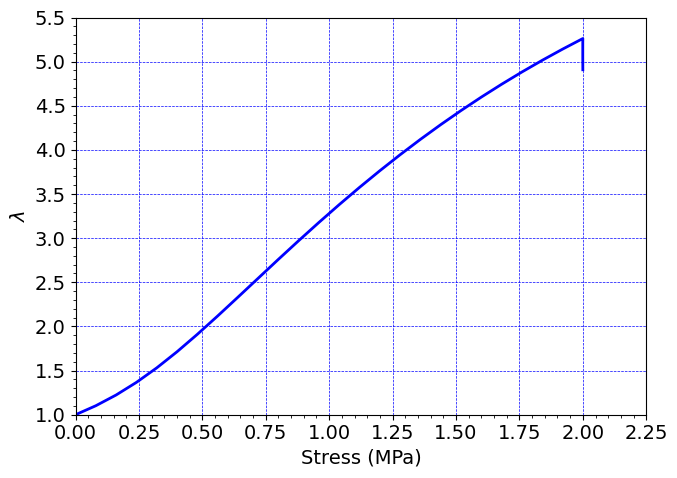

In [24]:
# Set up font size, initialize colors array
font = {'size'   : 14}
plt.rc('font', **font)
#
prop_cycle = plt.rcParams['axes.prop_cycle']
colors     = prop_cycle.by_key()['color']

# Only plot as far as we have time history data
ind = np.argmax(timeHist0[:])
   
# Create figure for stress-stretch curve.
#
fig = plt.figure() 
ax=fig.gca()  
#---------------------------------------------------------------------------------------------
plt.plot( timeHist2[0:ind]/(np.pi*R0*R0)/1000,(timeHist1[0:ind]/H0 +1), c='b', linewidth=2.0)
#---------------------------------------------------------------------------------------------
plt.xlim(0,2.25)
plt.ylim(1,5.5)
plt.grid(linestyle="--", linewidth=0.5, color='b')
ax.set_xlabel("Stress (MPa)",size=14)
ax.set_ylabel("$\lambda$",size=14)
#ax.set_title("Stretch versus stress curve", size=14, weight='normal')
#
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#plt.legend()
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
# Save figure
fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/axi_stress_stretch.png", dpi=600) 


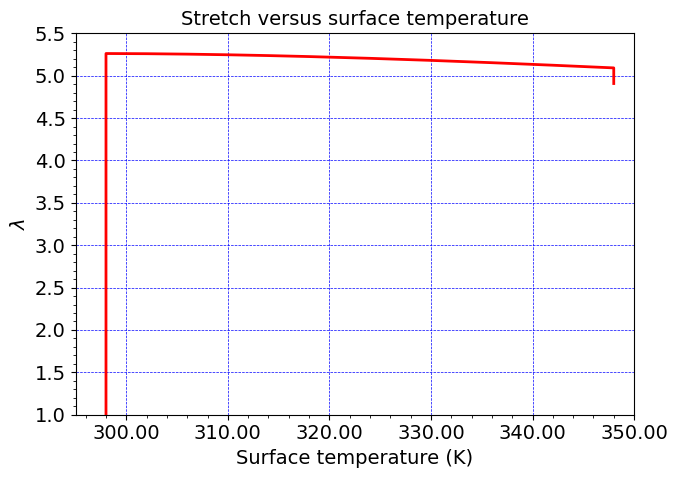

In [25]:
# Create figure for stretch versus temperature change 
#
fig = plt.figure() 
ax=fig.gca()  
#---------------------------------------------------------------------------------------------
plt.plot(timeHist3[0:ind], (timeHist1[0:ind]/H0 +1),  c='r', linewidth=2.0)
#---------------------------------------------------------------------------------------------
plt.xlim(295,350)
plt.ylim(1,5.5)
plt.grid(linestyle="--", linewidth=0.5, color='b')
ax.set_xlabel(r'Surface temperature (K)',size=14)
ax.set_ylabel("$\lambda$",size=14)
ax.set_title(r'Stretch versus surface temperature', size=14, weight='normal')
#
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#plt.legend()
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
# Save figure
fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/axi_temp_stretch.png", dpi=600) 